In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 96.9 MB/s eta 0:00:00:00:0100:01


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from collections import Counter


In [ ]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class HAM10000Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform if transform else transforms.ToTensor()
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image.float().to(device), torch.tensor(label, dtype=torch.long, device=device)

# Define transforms with data augmentation
def get_optimized_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Reduced size for faster training
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Reduced size for faster training
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

In [ ]:
# Define regular CNN model - simplified for better generalization
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate size after pooling operations
        # 128 -> 64 -> 32 -> 16
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
def create_quantum_circuit(n_qubits, n_layers):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def quantum_circuit(inputs, weights):
        # Angle encoding
        for i in range(n_qubits):
            qml.RY(inputs[i], wires=i)
        
        # Variational layers
        for l in range(n_layers):
            # Rotation gates with learned parameters
            for i in range(n_qubits):
                qml.RY(weights[l][i][0], wires=i)
                qml.RZ(weights[l][i][1], wires=i)
            
            # Entanglement
            for i in range(n_qubits - 1):
                qml.CZ(wires=[i, i + 1])
            
            if n_qubits > 1:
                qml.CZ(wires=[n_qubits - 1, 0])  # Connect last qubit to first
        
        # Measurement in computational basis
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    return quantum_circuit

# Define improved hybrid quantum-classical model
class HybridQuantumCNN(nn.Module):
    def __init__(self, n_qubits=6, n_qlayers=2, num_classes=7):
        super(HybridQuantumCNN, self).__init__()
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        
        # Classical CNN part - simplified
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected to reduce dimensions
        # 128 -> 64 -> 32
        self.fc_reduce = nn.Linear(32 * 32 * 32, n_qubits)
        
        # Quantum circuit
        self.quantum_circuit = create_quantum_circuit(n_qubits, n_qlayers)
        
        # Initialize quantum weights - more expressive parameterization
        weight_shapes = {"weights": (n_qlayers, n_qubits, 2)}  # 2 parameters per qubit per layer
        self.qlayer = qml.qnn.TorchLayer(self.quantum_circuit, weight_shapes)
        
        # Classical output layers with better capacity
        self.fc_hidden = nn.Linear(n_qubits, 32)
        self.fc_output = nn.Linear(32, num_classes)
        
    def forward(self, x):
        # Classical CNN feature extraction
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Reduce to quantum input dimension
        x = F.leaky_relu(self.fc_reduce(x))  # Use LeakyReLU for better gradients
        x = torch.tanh(x) * np.pi  # Scale to [-π, π] for rotation gates
        
        # Process batch through quantum circuit
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits, device=x.device)
        
        # Process in smaller batches to avoid memory issues with quantum circuit
        for i in range(batch_size):
            q_out[i] = self.qlayer(x[i])
        
        # Final classification layers
        x = F.relu(self.fc_hidden(q_out))
        x = self.fc_output(x)
        
        return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=10, model_name="model", patience=5, clip_value=1.0):
    best_val_acc = 0.0
    best_val_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    
    print(f"Starting training {model_name}...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds = []
        all_train_labels = []
        
        train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_loop:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            
            # Collect for metrics
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            # Update progress bar with current batch loss
            train_loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = accuracy_score(all_train_labels, all_train_preds)
        epoch_train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['train_f1'].append(epoch_train_f1)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_loop:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                
                # Collect for metrics
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                
                # Update progress bar with current batch loss
                val_loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = accuracy_score(all_val_labels, all_val_preds)
        epoch_val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_f1'].append(epoch_val_f1)
        
        # Print per-class metrics for validation
        class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
        val_f1_per_class = f1_score(all_val_labels, all_val_preds, average=None, zero_division=0)
        print(f'\nValidation F1 scores by class:')
        for i, class_name in enumerate(class_names):
            print(f'{class_name}: {val_f1_per_class[i]:.4f}', end=' | ')
        print()
        
        # Check distribution of predictions
        pred_counts = Counter(all_val_preds)
        print(f'Prediction distribution: {dict(pred_counts)}')
        
        # Step the scheduler
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Train F1: {epoch_train_f1:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val F1: {epoch_val_f1:.4f}')
        
        # Save best model based on F1 score (better for imbalanced data)
        if epoch_val_f1 > best_val_f1:
            best_val_f1 = epoch_val_f1
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            print(f'Saved new best model with validation F1: {best_val_f1:.4f}, Acc: {best_val_acc:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Validation F1 did not improve. Patience: {patience_counter}/{patience}')
            
        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    total_time = time.time() - start_time
    print(f'Training completed in {total_time/60:.2f} minutes')
    print(f'Best validation F1: {best_val_f1:.4f}, Accuracy: {best_val_acc:.4f}')
    
    # Load best model for return
    model.load_state_dict(torch.load(f'{model_name}_best.pth'))
    
    return model, history

In [ ]:
def evaluate_model(model, test_loader, criterion, model_name="model", class_names=None):
    if class_names is None:
        class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
        
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []  # Store probabilities for ROC analysis
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics with zero_division parameter to avoid warnings
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with zero
    
    # Per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    # Print results
    print(f'\nTest Results for {model_name}:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Check prediction distribution
    pred_counts = Counter(all_preds)
    print(f'Prediction distribution: {dict(pred_counts)}')
    
    print('\nPer-class metrics:')
    for i, class_name in enumerate(class_names):
        print(f'{class_name}: Precision={per_class_precision[i]:.4f}, '
              f'Recall={per_class_recall[i]:.4f}, '
              f'F1={per_class_f1[i]:.4f}')
    
    # Plot confusion matrix with percentages
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()
    
    # Also plot raw counts
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Counts) - {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix_counts.png')
    plt.close()
    
    results = {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall,
        'per_class_f1': per_class_f1,
        'confusion_matrix': cm,
        'confusion_matrix_norm': cm_norm,
        'all_probs': np.array(all_probs),
        'all_preds': np.array(all_preds),
        'all_labels': np.array(all_labels)
    }
    
    return results

# Improved comparison function
def compare_models(simple_history, hybrid_history, simple_results, hybrid_results, class_names=None):
    if class_names is None:
        class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
        
    # Plot training and validation metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss
    axes[0, 0].plot(simple_history['train_loss'], label='Simple CNN - Train')
    axes[0, 0].plot(simple_history['val_loss'], label='Simple CNN - Val')
    axes[0, 0].plot(hybrid_history['train_loss'], label='Hybrid Quantum CNN - Train')
    axes[0, 0].plot(hybrid_history['val_loss'], label='Hybrid Quantum CNN - Val')
    axes[0, 0].set_title('Loss Comparison')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Accuracy
    axes[0, 1].plot(simple_history['train_acc'], label='Simple CNN - Train')
    axes[0, 1].plot(simple_history['val_acc'], label='Simple CNN - Val')
    axes[0, 1].plot(hybrid_history['train_acc'], label='Hybrid Quantum CNN - Train')
    axes[0, 1].plot(hybrid_history['val_acc'], label='Hybrid Quantum CNN - Val')
    axes[0, 1].set_title('Accuracy Comparison')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # F1 Score
    axes[1, 0].plot(simple_history['train_f1'], label='Simple CNN - Train')
    axes[1, 0].plot(simple_history['val_f1'], label='Simple CNN - Val')
    axes[1, 0].plot(hybrid_history['train_f1'], label='Hybrid Quantum CNN - Train')
    axes[1, 0].plot(hybrid_history['val_f1'], label='Hybrid Quantum CNN - Val')
    axes[1, 0].set_title('F1 Score Comparison')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    
    # Prediction distribution
    simple_pred_counts = Counter(simple_results['all_preds'])
    hybrid_pred_counts = Counter(hybrid_results['all_preds'])
    true_label_counts = Counter(simple_results['all_labels'])
    
    simple_counts = [simple_pred_counts.get(i, 0) for i in range(len(class_names))]
    hybrid_counts = [hybrid_pred_counts.get(i, 0) for i in range(len(class_names))]
    true_counts = [true_label_counts.get(i, 0) for i in range(len(class_names))]
    
    x = np.arange(len(class_names))
    width = 0.25
    
    axes[1, 1].bar(x - width, true_counts, width, label='True Distribution')
    axes[1, 1].bar(x, simple_counts, width, label='Simple CNN')
    axes[1, 1].bar(x + width, hybrid_counts, width, label='Hybrid Quantum CNN')
    axes[1, 1].set_title('Prediction Distribution')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(class_names)
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison_training.png')
    plt.close()
    
    # Compare test results
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Simple CNN': [simple_results['accuracy'], simple_results['precision'], 
                       simple_results['recall'], simple_results['f1']],
        'Hybrid Quantum CNN': [hybrid_results['accuracy'], hybrid_results['precision'], 
                               hybrid_results['recall'], hybrid_results['f1']]
    })
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    ax = comparison.plot(x='Metric', y=['Simple CNN', 'Hybrid Quantum CNN'], 
                         kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Add values on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')
        
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png')
    plt.close()
    
    # Compare per-class F1 scores
    plt.figure(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.35
    
    plt.bar(x - width/2, simple_results['per_class_f1'], width, label='Simple CNN')
    plt.bar(x + width/2, hybrid_results['per_class_f1'], width, label='Hybrid Quantum CNN')
    
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Class')
    plt.xticks(x, class_names)
    plt.legend()
    plt.tight_layout()
    plt.savefig('f1_score_by_class.png')
    plt.close()
    
    # Print detailed comparison
    print("\nModel Comparison Summary:")
    print(comparison.to_string(index=False))
    
    return comparison

In [ ]:
def prepare_dataset(base_path, use_balanced_sampler=True):
    metadata_path = os.path.join(base_path, 'HAM10000_metadata.csv')
    image_dir_1 = os.path.join(base_path, 'HAM10000_images_part_1')
    image_dir_2 = os.path.join(base_path, 'HAM10000_images_part_2')
    
    # Load metadata
    print("Loading metadata...")
    metadata = pd.read_csv(metadata_path)
    
    # Create label mapping
    lesion_type_dict = {
        'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3,
        'akiec': 4, 'vasc': 5, 'df': 6
    }
    metadata['label'] = metadata['dx'].map(lesion_type_dict)
    
    # Collect valid image paths and labels
    print("Processing image paths...")
    valid_image_paths = []
    valid_labels = []
    for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc='Processing image paths'):
        image_id = row['image_id']
        label = row['label']
        image_path_1 = os.path.join(image_dir_1, image_id + '.jpg')
        image_path_2 = os.path.join(image_dir_2, image_id + '.jpg')
        if os.path.exists(image_path_1):
            valid_image_paths.append(image_path_1)
            valid_labels.append(label)
        elif os.path.exists(image_path_2):
            valid_image_paths.append(image_path_2)
            valid_labels.append(label)
    
    print(f"Found {len(valid_image_paths)} valid images")
    
    # Print class distribution
    label_counts = Counter(valid_labels)
    print("Class distribution:")
    for label, count in sorted(label_counts.items()):
        class_name = list(lesion_type_dict.keys())[list(lesion_type_dict.values()).index(label)]
        print(f"{class_name} (class {label}): {count} images ({count/len(valid_labels)*100:.2f}%)")
    
    # Calculate class weights for loss function
    class_counts = np.bincount(valid_labels)
    n_samples = len(valid_labels)
    n_classes = len(np.unique(valid_labels))
    class_weights = n_samples / (n_classes * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
    # Split dataset
    print("Splitting dataset...")
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        valid_image_paths, valid_labels, test_size=0.2, random_state=42, stratify=valid_labels
    )
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.15, random_state=42, stratify=train_labels
    )
    
    print(f"Train set: {len(train_paths)} images")
    print(f"Validation set: {len(val_paths)} images")
    print(f"Test set: {len(test_paths)} images")
    
    # Get transforms
    train_transform, val_transform = get_optimized_transforms()
    
    # Create datasets
    print("Creating datasets...")
    train_dataset = HAM10000Dataset(train_paths, train_labels, transform=train_transform)
    val_dataset = HAM10000Dataset(val_paths, val_labels, transform=val_transform)
    test_dataset = HAM10000Dataset(test_paths, test_labels, transform=val_transform)
    
    # Create balanced sampler for training if requested
    if use_balanced_sampler:
        print("Creating weighted random sampler for balanced training...")
        train_labels_tensor = torch.tensor(train_labels)
        class_sample_count = torch.tensor(
            [(train_labels_tensor == t).sum() for t in torch.unique(train_labels_tensor, sorted=True)]
        )
        weight = 1. / class_sample_count.float()
        samples_weight = torch.tensor([weight[t] for t in train_labels_tensor])
        sampler = torch.utils.data.WeightedRandomSampler(
            samples_weight, len(samples_weight), replacement=True
        )
        train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=0)
        train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    else:
        # Create regular data loaders if not using balanced sampler
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, test_loader, class_weights

def main():
    # Path to dataset
    base_path = '/kaggle/input/skin-cancer-mnist-ham10000'  # Adjust as needed
    
    # Prepare dataset
    print("Preparing dataset...")
    train_loader, val_loader, test_loader, class_weights = prepare_dataset(base_path, use_balanced_sampler=True)
    
    # Send class weights to device
    class_weights = class_weights.to(device)
    
    # Initialize models
    print("Initializing models...")
    simple_model = SimpleCNN(num_classes=7).to(device)
    hybrid_model = HybridQuantumCNN(n_qubits=6, n_qlayers=2, num_classes=7).to(device)
    
    # Define loss function with class weights for handling imbalance
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Define optimizers with weight decay for regularization
    simple_optimizer = optim.AdamW(simple_model.parameters(), lr=0.001, weight_decay=1e-4)
    hybrid_optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Learning rate schedulers
    simple_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        simple_optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    hybrid_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        hybrid_optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Train and evaluate simple CNN
    print("\n" + "="*50)
    print("Training Simple CNN...")
    simple_model, simple_history = train_model(
        simple_model, train_loader, val_loader, criterion, simple_optimizer, simple_scheduler,
        num_epochs=20, model_name="simple_cnn", patience=7, clip_value=1.0
    )
    
    print("\n" + "="*50)
    print("Evaluating Simple CNN...")
    simple_results = evaluate_model(simple_model, test_loader, criterion, model_name="simple_cnn")
    
    # Train and evaluate hybrid quantum CNN
    print("\n" + "="*50)
    print("Training Hybrid Quantum CNN...")
    hybrid_model, hybrid_history = train_model(
        hybrid_model, train_loader, val_loader, criterion, hybrid_optimizer, hybrid_scheduler,
        num_epochs=20, model_name="hybrid_quantum_cnn", patience=7, clip_value=1.0
    )
    
    print("\n" + "="*50)
    print("Evaluating Hybrid Quantum CNN...")
    hybrid_results = evaluate_model(hybrid_model, test_loader, criterion, model_name="hybrid_quantum_cnn")
    
    # Compare models
    print("\n" + "="*50)
    print("Comparing Models...")
    compare_models(simple_history, hybrid_history, simple_results, hybrid_results)
    
    # Save models
    torch.save(simple_model.state_dict(), "simple_cnn_final.pth")
    torch.save(hybrid_model.state_dict(), "hybrid_quantum_cnn_final.pth")
    
    # Save results
    with open("simple_cnn_results.pkl", "wb") as f:
        pickle.dump(simple_results, f)
    with open("hybrid_quantum_cnn_results.pkl", "wb") as f:
        pickle.dump(hybrid_results, f)
    
    print("\nExperiment completed successfully!")

if __name__ == "__main__":
    # Add import for pickle
    import pickle
    
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Run experiment
    main()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class HAM10000Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform if transform else transforms.ToTensor()
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image.float().to(device), torch.tensor(label, dtype=torch.long, device=device)

# Define transforms with data augmentation
def get_optimized_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# Define regular CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate size after pooling operations
        # 224 -> 112 -> 56 -> 28
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Define the improved quantum circuit
def create_improved_quantum_circuit(n_qubits=4, n_qlayers=3):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def quantum_circuit(inputs, weights):
        # More sophisticated input embedding
        for i in range(n_qubits):
            qml.RY(inputs[i], wires=i)
            qml.RZ(inputs[i], wires=i)
        
        # More complex variational layers
        for l in range(n_qlayers):
            # Rotation gates
            for i in range(n_qubits):
                qml.RY(weights[l][i], wires=i)
                qml.RZ(weights[l][i+n_qubits], wires=i)
            
            # Entangling gates with more connectivity
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i+1) % n_qubits])
                qml.CNOT(wires=[i, (i+2) % n_qubits])
            
            # Add measurement-based feature map
            # Fixed: Changed n_layers to layers parameter
            qml.RandomLayers(weights[l][2*n_qubits:], layers=1, wires=range(n_qubits))
        
        # More expressive readout
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    return quantum_circuit

# Define hybrid quantum-classical model
class ImprovedHybridQuantumCNN(nn.Module):
    def __init__(self, n_qubits=4, n_qlayers=3, num_classes=7):
        super(ImprovedHybridQuantumCNN, self).__init__()
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        
        # Enhanced classical feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected to reduce dimensions
        self.fc_reduce = nn.Linear(128 * 28 * 28, n_qubits)
        
        # Quantum circuit
        self.quantum_circuit = create_improved_quantum_circuit(n_qubits, n_qlayers)
        
        # Initialize quantum weights with more parameters
        weight_shapes = {
            "weights": (n_qlayers, 3*n_qubits)  # More weights for complexity
        }
        self.qlayer = qml.qnn.TorchLayer(self.quantum_circuit, weight_shapes)
        
        # Classical output layers with dropout
        self.classifier = nn.Sequential(
            nn.Linear(n_qubits, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # Classical feature extraction
        x = self.features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Reduce to quantum input dimension
        x = self.fc_reduce(x)
        x = torch.tanh(x) * np.pi  # Scale to [-π, π] for rotation gates
        
        # Process each example through the quantum circuit
        q_out = torch.stack([self.qlayer(x[i]) for i in range(x.shape[0])])
        
        # Final classification
        x = self.classifier(q_out)
        
        return x

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, model_name="model"):
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    print(f"Starting training {model_name}...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_loop:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_loop.set_postfix(loss=loss.item(), acc=correct/total)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_loop:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar
                val_loop.set_postfix(loss=loss.item(), acc=correct/total)
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        # Step the scheduler
        if scheduler:
            scheduler.step(epoch_val_loss)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            print(f'Saved new best model with validation accuracy: {best_val_acc:.4f}')
    
    total_time = time.time() - start_time
    print(f'Training completed in {total_time/60:.2f} minutes')
    print(f'Best validation accuracy: {best_val_acc:.4f}')
    
    return model, history

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion, model_name="model"):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Per-class metrics
    class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
    per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    # Print results
    print(f'\nTest Results for {model_name}:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    print('\nPer-class metrics:')
    for i, class_name in enumerate(class_names):
        print(f'{class_name}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}')
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()
    
    results = {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall,
        'per_class_f1': per_class_f1,
        'confusion_matrix': cm
    }
    
    return results

# Function to compare models
def compare_models(simple_history, hybrid_history, simple_results, hybrid_results):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(simple_history['train_loss'], label='Simple CNN - Train')
    plt.plot(simple_history['val_loss'], label='Simple CNN - Val')
    plt.plot(hybrid_history['train_loss'], label='Hybrid Quantum CNN - Train')
    plt.plot(hybrid_history['val_loss'], label='Hybrid Quantum CNN - Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(simple_history['train_acc'], label='Simple CNN - Train')
    plt.plot(simple_history['val_acc'], label='Simple CNN - Val')
    plt.plot(hybrid_history['train_acc'], label='Hybrid Quantum CNN - Train')
    plt.plot(hybrid_history['val_acc'], label='Hybrid Quantum CNN - Val')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison_training.png')
    plt.close()
    
    # Compare test results
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Simple CNN': [simple_results['accuracy'], simple_results['precision'], simple_results['recall'], simple_results['f1']],
        'Hybrid Quantum CNN': [hybrid_results['accuracy'], hybrid_results['precision'], hybrid_results['recall'], hybrid_results['f1']]
    })
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    comparison.plot(x='Metric', y=['Simple CNN', 'Hybrid Quantum CNN'], kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for i, v in enumerate(comparison['Simple CNN']):
        plt.text(i-0.1, v+0.01, f"{v:.4f}", ha='center')
    for i, v in enumerate(comparison['Hybrid Quantum CNN']):
        plt.text(i+0.1, v+0.01, f"{v:.4f}", ha='center')
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png')
    plt.close()
    
    # F1 score comparison per class
    plt.figure(figsize=(12, 6))
    x = np.arange(len(simple_results['per_class_f1']))
    width = 0.35
    
    plt.bar(x - width/2, simple_results['per_class_f1'], width, label='Simple CNN')
    plt.bar(x + width/2, hybrid_results['per_class_f1'], width, label='Hybrid Quantum CNN')
    
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Class')
    plt.xticks(x, ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'])
    plt.legend()
    plt.tight_layout()
    plt.savefig('f1_score_by_class.png')
    plt.close()
    
    # Print detailed comparison
    print("\nModel Comparison Summary:")
    print(comparison.to_string(index=False))
    
    return comparison

# Function to prepare dataset
def prepare_dataset(base_path):
    metadata_path = os.path.join(base_path, 'HAM10000_metadata.csv')
    image_dir_1 = os.path.join(base_path, 'HAM10000_images_part_1')
    image_dir_2 = os.path.join(base_path, 'HAM10000_images_part_2')
    
    # Load metadata
    print("Loading metadata...")
    metadata = pd.read_csv(metadata_path)
    
    # Create label mapping
    lesion_type_dict = {
        'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3,
        'akiec': 4, 'vasc': 5, 'df': 6
    }
    metadata['label'] = metadata['dx'].map(lesion_type_dict)
    
    # Collect valid image paths and labels
    print("Processing image paths...")
    valid_image_paths = []
    valid_labels = []
    for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc='Processing image paths'):
        image_id = row['image_id']
        label = row['label']
        image_path_1 = os.path.join(image_dir_1, image_id + '.jpg')
        image_path_2 = os.path.join(image_dir_2, image_id + '.jpg')
        if os.path.exists(image_path_1):
            valid_image_paths.append(image_path_1)
            valid_labels.append(label)
        elif os.path.exists(image_path_2):
            valid_image_paths.append(image_path_2)
            valid_labels.append(label)
    
    print(f"Found {len(valid_image_paths)} valid images")
    
    # Calculate class weights
    class_counts = pd.Series(valid_labels).value_counts().sort_index()
    class_weights = 1.0 / class_counts  # Inverse of class frequencies
    class_weights = torch.tensor(class_weights.values, dtype=torch.float32)
    
    # Split dataset
    print("Splitting dataset...")
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        valid_image_paths, valid_labels, test_size=0.2, random_state=42, stratify=valid_labels
    )
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.15, random_state=42, stratify=train_labels
    )
    
    print(f"Train set: {len(train_paths)} images")
    print(f"Validation set: {len(val_paths)} images")
    print(f"Test set: {len(test_paths)} images")
    
    # Get transforms
    train_transform, val_transform = get_optimized_transforms()
    
    # Create datasets
    print("Creating datasets...")
    train_dataset = HAM10000Dataset(train_paths, train_labels, transform=train_transform)
    val_dataset = HAM10000Dataset(val_paths, val_labels, transform=val_transform)
    test_dataset = HAM10000Dataset(test_paths, test_labels, transform=val_transform)
    
    # Create dataloaders
    print("Creating data loaders...")
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, test_loader, class_weights

# Main function to run experiments
def run_experiments(train_loader, val_loader, test_loader, class_weights, epochs=10):
    # Define models
    simple_cnn = SimpleCNN(num_classes=7).to(device)
    hybrid_qcnn = ImprovedHybridQuantumCNN(n_qubits=4, n_qlayers=3, num_classes=7).to(device)
    
    # Define loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    # Optimizers with different learning rates
    simple_optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001, weight_decay=1e-4)
    hybrid_optimizer = optim.Adam(hybrid_qcnn.parameters(), lr=0.0005, weight_decay=1e-4)
    
    # Schedulers
    simple_scheduler = optim.lr_scheduler.ReduceLROnPlateau(simple_optimizer, mode='min', factor=0.5, patience=3)
    hybrid_scheduler = optim.lr_scheduler.ReduceLROnPlateau(hybrid_optimizer, mode='min', factor=0.5, patience=3)
    
    # Train the models
    simple_cnn, simple_history = train_model(
        simple_cnn, train_loader, val_loader, criterion, 
        simple_optimizer, simple_scheduler, num_epochs=epochs, 
        model_name="simple_cnn"
    )
    
    hybrid_qcnn, hybrid_history = train_model(
        hybrid_qcnn, train_loader, val_loader, criterion, 
        hybrid_optimizer, hybrid_scheduler, num_epochs=epochs,
        model_name="hybrid_qcnn"
    )
    
    # Evaluate the models
    simple_results = evaluate_model(simple_cnn, test_loader, criterion, model_name="Simple CNN")
    hybrid_results = evaluate_model(hybrid_qcnn, test_loader, criterion, model_name="Hybrid Quantum CNN")
    
    # Compare the models
    comparison = compare_models(simple_history, hybrid_history, simple_results, hybrid_results)
    
    return simple_cnn, hybrid_qcnn, comparison

# Main execution
def main():
    # Set base path (modify this to your dataset location)
    base_path = '/kaggle/input/skin-cancer-mnist-ham10000'
    
    # Prepare dataset
    train_loader, val_loader, test_loader, class_weights = prepare_dataset(base_path)
    
    # Set number of epochs
    NUM_EPOCHS = 10  # Adjust based on your computational resources
    
    # Run the experiments
    simple_model, hybrid_model, results = run_experiments(
        train_loader, val_loader, test_loader, class_weights, epochs=NUM_EPOCHS
    )
    
    print("Experiment completed!")

if __name__ == "__main__":
    main()


Training Modified Quantum Hybrid Model...


Validating Epoch 1/20: 100%|██████████| 126/126 [02:07<00:00,  1.01s/it]


Epoch 1: Train Acc: 12.17%, Val Acc: 11.98%


Validating Epoch 2/20: 100%|██████████| 126/126 [02:09<00:00,  1.03s/it]


Epoch 2: Train Acc: 12.33%, Val Acc: 17.52%


Validating Epoch 3/20: 100%|██████████| 126/126 [02:06<00:00,  1.01s/it]


Epoch 3: Train Acc: 13.49%, Val Acc: 19.27%


Validating Epoch 4/20: 100%|██████████| 126/126 [02:06<00:00,  1.00s/it]


Epoch 4: Train Acc: 16.59%, Val Acc: 27.86%


Validating Epoch 5/20: 100%|██████████| 126/126 [02:07<00:00,  1.01s/it]


Epoch 5: Train Acc: 25.15%, Val Acc: 38.79%


Validating Epoch 6/20: 100%|██████████| 126/126 [02:07<00:00,  1.01s/it]


Epoch 6: Train Acc: 37.79%, Val Acc: 58.91%


Validating Epoch 7/20: 100%|██████████| 126/126 [02:09<00:00,  1.03s/it]


Epoch 7: Train Acc: 51.05%, Val Acc: 64.20%


Validating Epoch 8/20: 100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Epoch 8: Train Acc: 60.33%, Val Acc: 65.55%


Validating Epoch 9/20: 100%|██████████| 126/126 [02:07<00:00,  1.02s/it]


Epoch 9: Train Acc: 64.43%, Val Acc: 65.25%


Validating Epoch 10/20: 100%|██████████| 126/126 [02:07<00:00,  1.02s/it]


Epoch 10: Train Acc: 65.76%, Val Acc: 66.15%


Validating Epoch 11/20: 100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Epoch 11: Train Acc: 66.30%, Val Acc: 65.65%


Validating Epoch 12/20: 100%|██████████| 126/126 [02:05<00:00,  1.00it/s]


Epoch 12: Train Acc: 66.51%, Val Acc: 66.55%


Validating Epoch 13/20: 100%|██████████| 126/126 [02:06<00:00,  1.00s/it]


Epoch 13: Train Acc: 66.63%, Val Acc: 66.70%


Validating Epoch 14/20: 100%|██████████| 126/126 [02:06<00:00,  1.00s/it]


Epoch 14: Train Acc: 66.59%, Val Acc: 66.45%


Validating Epoch 15/20: 100%|██████████| 126/126 [02:07<00:00,  1.01s/it]


Epoch 15: Train Acc: 66.65%, Val Acc: 66.50%


Validating Epoch 16/20: 100%|██████████| 126/126 [02:06<00:00,  1.01s/it]


Epoch 16: Train Acc: 66.75%, Val Acc: 66.15%


Validating Epoch 17/20: 100%|██████████| 126/126 [02:07<00:00,  1.01s/it]


Epoch 17: Train Acc: 66.76%, Val Acc: 66.35%


Validating Epoch 18/20: 100%|██████████| 126/126 [02:07<00:00,  1.02s/it]


Epoch 18: Train Acc: 66.65%, Val Acc: 66.50%


Validating Epoch 19/20: 100%|██████████| 126/126 [02:06<00:00,  1.00s/it]


Epoch 19: Train Acc: 66.65%, Val Acc: 66.50%


Validating Epoch 20/20: 100%|██████████| 126/126 [02:06<00:00,  1.00s/it]


Epoch 20: Train Acc: 66.76%, Val Acc: 66.65%

Final Results:
Modified Quantum Model Best Validation Accuracy: 66.70%


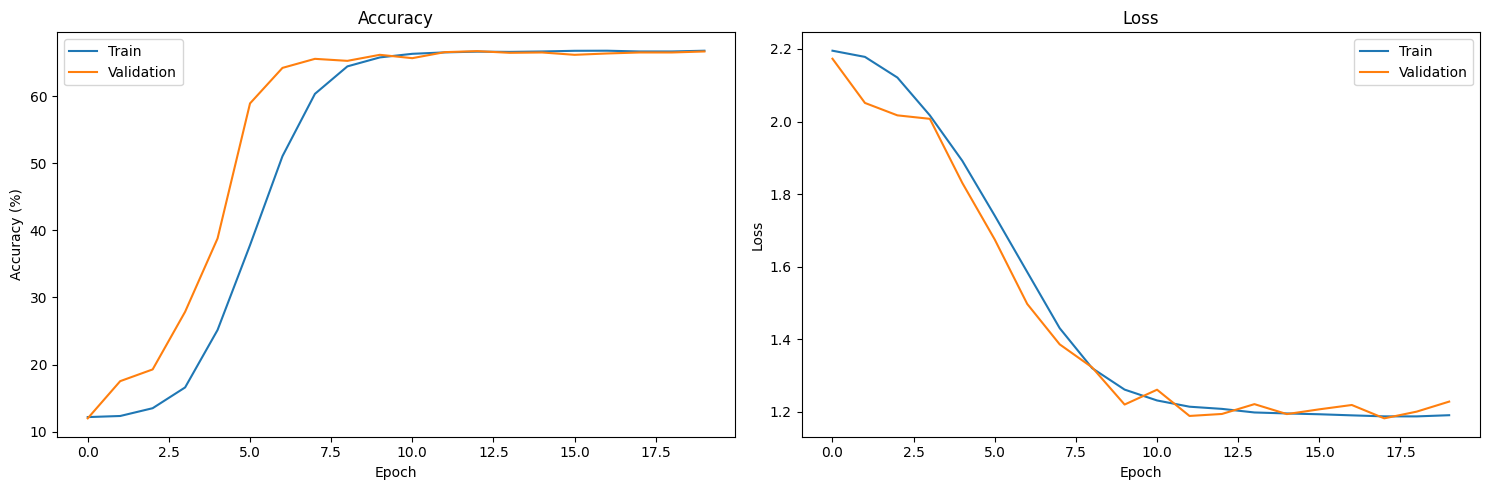

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pennylane as qml
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HAM10000Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform if transform else transforms.ToTensor()
        
        self.images = []
        for path in image_paths:
            img = Image.open(path).convert("RGB")
            self.images.append(img.copy())
            img.close()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image.to(device), torch.tensor(label, dtype=torch.long, device=device)

def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(0.2, 0.2, 0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

class ImprovedQuantumCircuit(nn.Module):
    def __init__(self, n_qubits=8, n_layers=3):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        @qml.qnode(self.dev, interface="torch")
        def quantum_circuit(inputs, weights):
            # AngleEmbedding instead of AmplitudeEmbedding
            qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
            
            # Multiple layers of parameterized quantum gates
            for l in range(n_layers):
                # Rotation layer
                for i in range(n_qubits):
                    qml.RX(weights[l*3*n_qubits + i], wires=i)
                    qml.RY(weights[l*3*n_qubits + n_qubits + i], wires=i)
                    qml.RZ(weights[l*3*n_qubits + 2*n_qubits + i], wires=i)
                
                # Entangling layer - circular pattern
                for i in range(n_qubits):
                    qml.CNOT(wires=[i, (i + 1) % n_qubits])
                
                # Additional entangling connections
                if l % 2 == 0:  # Alternate layer connections
                    for i in range(0, n_qubits, 2):
                        qml.CNOT(wires=[i, (i + 2) % n_qubits])
            
            # Measurement layer
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        
        self.quantum_circuit = quantum_circuit
        self.weights = nn.Parameter(torch.randn(3 * n_qubits * n_layers, device=device) * 0.1)
    
    def forward(self, x):
        q_out = self.quantum_circuit(x, self.weights)
        return torch.tensor(q_out, dtype=torch.float32, device=device)

class ModifiedQuantumHybridModel(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        
        # Custom CNN backbone instead of ResNet50
        self.backbone = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Third convolutional block
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # Fourth convolutional block
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # Fifth convolutional block
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            # Global average pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Feature reduction pathway
        self.feature_reduction = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 8)
        )
        
        # Quantum circuit with 8 qubits and 3 layers
        self.quantum_layer = ImprovedQuantumCircuit(n_qubits=8, n_layers=3)
        
        # Enhanced classical post-processing
        self.classifier = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        ).to(device)
    
    def forward(self, x):
        x = x.to(device)
        # Extract features using the backbone
        features = self.backbone(x)
        # Flatten the features
        features = features.view(features.size(0), -1)
        # Apply feature reduction
        features = self.feature_reduction(features)
        # Apply quantum processing
        quantum_features = torch.stack([self.quantum_layer(features[i]) for i in range(features.shape[0])])
        # Final classification
        return self.classifier(quantum_features)

def train_and_evaluate(model, train_loader, val_loader, device, epochs=20):
    criterion = nn.CrossEntropyLoss()
    
    # Separate learning rates for classical and quantum parts
    classical_params = list(model.backbone.parameters()) + list(model.feature_reduction.parameters()) + list(model.classifier.parameters())
    quantum_params = list(model.quantum_layer.parameters())
    
    optimizer = torch.optim.AdamW([
        {'params': classical_params, 'lr': 0.0001, 'weight_decay': 0.01},
        {'params': quantum_params, 'lr': 0.01, 'weight_decay': 0.001}
    ])
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[0.0001, 0.01],
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )
    
    model.to(device)
    best_val_acc = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Validating Epoch {epoch+1}/{epochs}'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_modified_quantum_hybrid_model.pth')
    
    return history

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Dataset paths for Kaggle
    base_path = '/kaggle/input/skin-cancer-mnist-ham10000'
    metadata_path = os.path.join(base_path, 'HAM10000_metadata.csv')
    image_dir_1 = os.path.join(base_path, 'HAM10000_images_part_1')
    image_dir_2 = os.path.join(base_path, 'HAM10000_images_part_2')
    
    # Load metadata
    metadata = pd.read_csv(metadata_path)
    
    # Create label mapping
    lesion_type_dict = {
        'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3,
        'akiec': 4, 'vasc': 5, 'df': 6
    }
    metadata['label'] = metadata['dx'].map(lesion_type_dict)
    
    # Collect valid image paths and labels
    valid_image_paths = []
    valid_labels = []
    
    for _, row in metadata.iterrows():
        image_id = row['image_id']
        label = row['label']
        
        image_path_1 = os.path.join(image_dir_1, image_id + '.jpg')
        image_path_2 = os.path.join(image_dir_2, image_id + '.jpg')
        
        if os.path.exists(image_path_1):
            valid_image_paths.append(image_path_1)
            valid_labels.append(label)
        elif os.path.exists(image_path_2):
            valid_image_paths.append(image_path_2)
            valid_labels.append(label)
    
    # Split data
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        valid_image_paths, valid_labels, test_size=0.2, random_state=42, stratify=valid_labels
    )
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = HAM10000Dataset(train_paths, train_labels, transform=train_transform)
    val_dataset = HAM10000Dataset(val_paths, val_labels, transform=val_transform)
    
    # Create dataloaders with increased batch size
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    # Train and evaluate modified quantum model
    print("\nTraining Modified Quantum Hybrid Model...")
    quantum_model = ModifiedQuantumHybridModel().to(device)
    quantum_history = train_and_evaluate(quantum_model, train_loader, val_loader, device, epochs=20)
    
    # Plot and save results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(quantum_history['train_acc'], label='Train')
    plt.plot(quantum_history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(quantum_history['train_loss'], label='Train')
    plt.plot(quantum_history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('modified_quantum_model_performance.png')
    
    print("\nFinal Results:")
    print(f"Modified Quantum Model Best Validation Accuracy: {max(quantum_history['val_acc']):.2f}%")

main()